## FORECASTING TIME SERIES (Graphical Solution)<br>
<span><strong>Goal: </strong>Pronosticating monthly sales per store (2013-2015)</span>

In [19]:
#importing libraries 
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns
#plotly libraries 
import plotly.express as px
import plotly.graph_objects as go
#used to graph plotly in Jupyter Notebook
import plotly.offline as pyo
pyo.init_notebook_mode()

#Time Series Libraries 
import matplotlib.dates as mdates
%matplotlib inline
import statsmodels.api as sm
import tensorflow as tf

Extracting all files from zip folders

In [20]:
from zipfile import ZipFile
with ZipFile('data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [21]:
#importing data 
#zipped csv files 
items = pd.read_csv('items.csv.zip')
sales_train = pd.read_csv('sales_train.csv.zip')
sample_submission = pd.read_csv('sample_submission.csv.zip')
test = pd.read_csv('test.csv.zip')
#csv files
categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [22]:
len(sample_submission.item_cnt_month), len(test), len(sales_train)

(214200, 214200, 2935849)

In [23]:
test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

### EXPLORATORY DATA ANALYSIS (EDA)

Joining all tables

In [24]:
#---Complete data set----
main_df = pd.merge(sales_train, items, on='item_id', how='left')
#each item belongs only to one category
main_df = pd.merge(main_df, categories, on='item_category_id', how='left')
main_df = pd.merge(main_df, shops, on='shop_id', how='left')

#---Test data set----
test_df = pd.merge(test, items, on='item_id', how='left')
test_df = pd.merge(test_df, categories, on='item_category_id', how='left')
test_df = pd.merge(test_df, shops, on='shop_id', how='left')

In [25]:
main_df.head(1)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154       999.0           1.0   

           item_name  item_category_id item_category_name  \
0  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray   

                shop_name  
0  Ярославль ТЦ "Альтаир"

<strong>Summary Statistics</strong>

In [26]:
main_df.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day  \
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06   
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00   
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00   
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01   
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00   
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00   
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00   
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03   

       item_category_id  
count      2.935849e+06  
mean       4.000138e+01  
std        1.710076e+01  
min        0.000000e+00  
25%        2.800000e+01  
50%        4.000000e+01  
75%        5.500000e+01  
max        8.300000e+01

**Shops Analysis**<br>
<i>Note that we are still not taking into consideration all the refunds (represented as negative income in sales)</i>

In [27]:
print('There are ' + str(len(main_df.shop_id.unique())) + ' shops in the database')

There are 60 shops in the database


In [28]:
shops = main_df['shop_name'].unique()
#creating revenue column 
main_df['revenue'] = (main_df.item_price)*(main_df.item_cnt_day)
mkt_share = main_df[['shop_name','revenue']]


In [29]:
#AS INDEX False
mkt_share = mkt_share.groupby(by=['shop_name'], as_index= False).sum()
mkt_share['Percentage'] = round((mkt_share.revenue / (mkt_share.revenue.sum()))*100, 2)

Pie Chart (Not very inituitive with the distribution of our data)

In [30]:
fig = px.pie(mkt_share, values='revenue', names='shop_name',
             title='Market Share per Store',
             hover_data=['Percentage'])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

**Categories**

In [31]:
cat_count = pd.DataFrame(main_df.item_category_name.value_counts()).reset_index()
#fetching top 20 categories with the most sales
cat_count = cat_count.head(20)

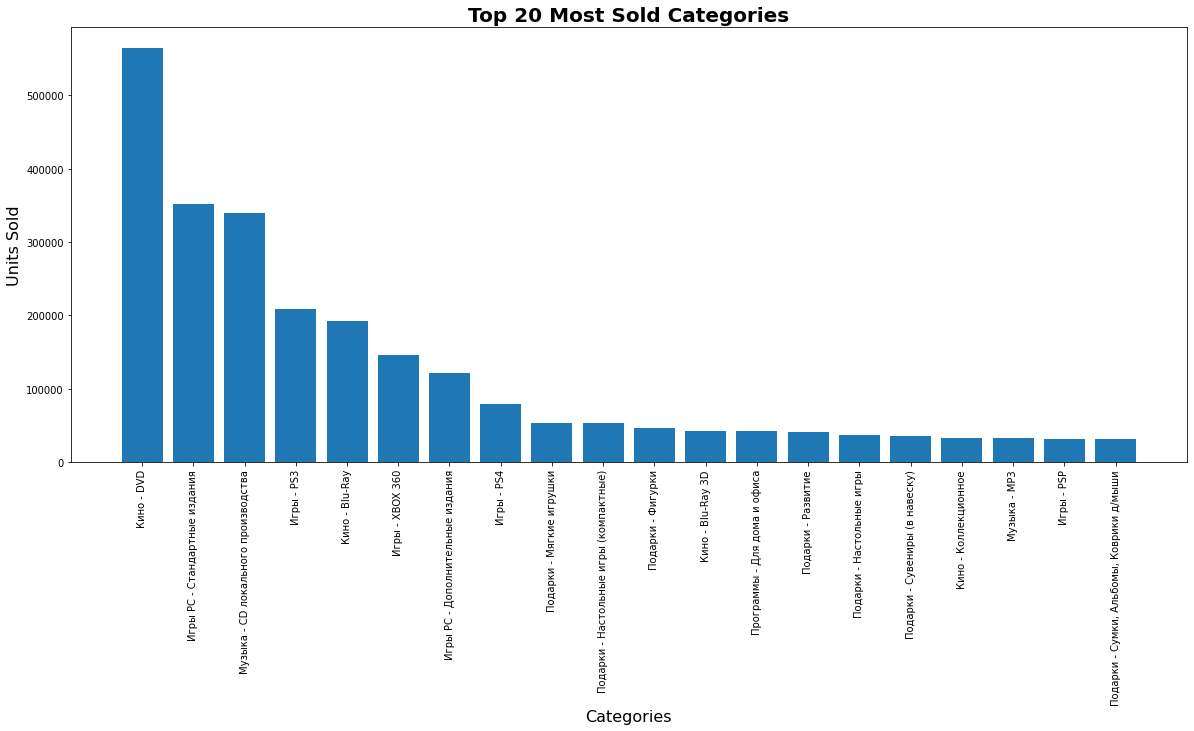

In [32]:
x = cat_count['index']
y = cat_count['item_category_name']

fig = figure(figsize=(20,8))
fig.set_facecolor('white')
plt.title('Top 20 Most Sold Categories', size=20, fontweight='bold')
plt.bar(x,y)
#setting labels 
plt.xlabel('Categories', size= 16)
plt.ylabel('Units Sold', size=16)
#rotating xlabels
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)
plt.show()

**Sales Time Series**<br>
By years

In [33]:
len(main_df.item_id.unique())

21807

In [34]:
#library for hiding console messages 
import warnings
warnings.filterwarnings('ignore')

#changing date to date format 
main_df.date = pd.to_datetime(main_df.date, infer_datetime_format=True)

In [35]:
revenue_time = main_df[['date','revenue']]

#adding total sales per day
revenue_time = (revenue_time.groupby(by=['date'], as_index=True).sum())

#Dfs for all 3 years
rev_2013 = revenue_time[revenue_time.index.year == 2013]
rev_2014 = revenue_time[revenue_time.index.year == 2014]
rev_2015 = revenue_time[revenue_time.index.year == 2015]

#Transforming Pandas Df --> Pandas Series (1D df)
rev_2013 = rev_2013.squeeze()
rev_2014 = rev_2014.squeeze()
rev_2015 = rev_2015.squeeze()

#they are not all the same size
len(rev_2013),len(rev_2014),len(rev_2015)

(365, 365, 304)

<i>Reindexing Series Objects</i>

In [36]:
#homogenizing length of uncomplete dfs to 365 entries
idx = pd.date_range('2015-01-01', '2015-12-31')
rev_2015 = rev_2015.reindex(idx, fill_value=0)
print(rev_2015)

2015-01-01    2893438.00
2015-01-02    3499096.59
2015-01-03    3175882.01
2015-01-04    1693925.20
2015-01-05    2626787.23
                 ...    
2015-12-27          0.00
2015-12-28          0.00
2015-12-29          0.00
2015-12-30          0.00
2015-12-31          0.00
Freq: D, Name: revenue, Length: 365, dtype: float64


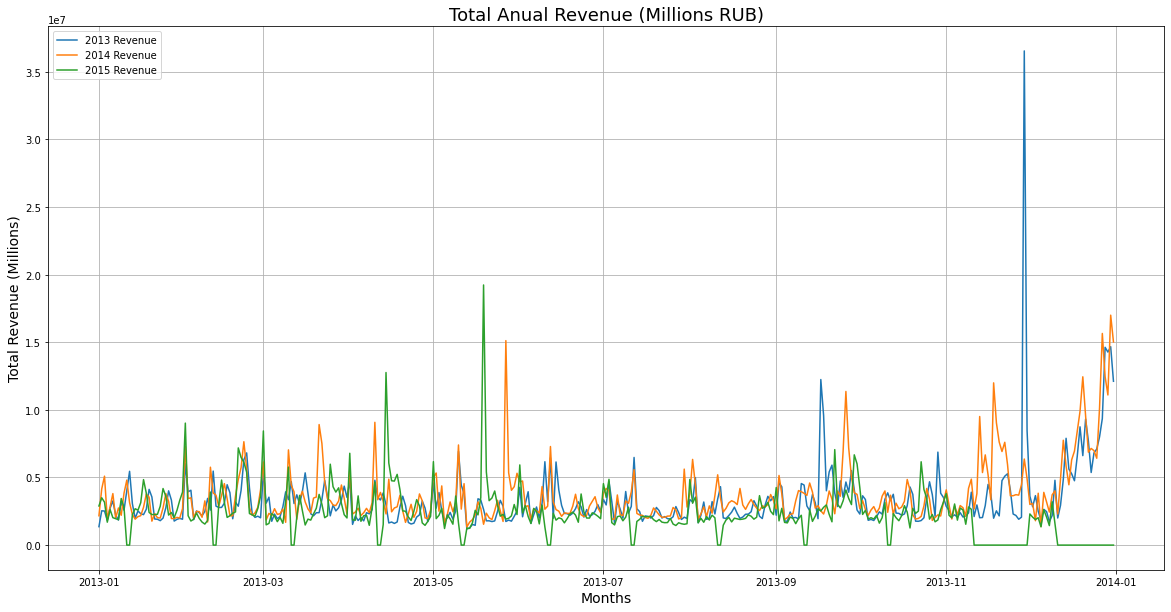

In [37]:
#plotting time series
fig = figure(figsize=(20,10))
fig.set_facecolor('white')
plt.plot(rev_2013.index, rev_2013.values)
plt.plot(rev_2013.index, rev_2014.values)
plt.plot(rev_2013.index, rev_2015.values)

#labels and legend
plt.title('Total Anual Revenue (Millions RUB)', size=18)
plt.xlabel('Months', size=14)
plt.ylabel('Total Revenue (Millions)', size=14)
plt.legend(['2013 Revenue','2014 Revenue','2015 Revenue'], loc=2)

#adding grid 
plt.grid()

plt.show()

### DATA CLEANSING

In [38]:
#There are no null values
main_df.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
revenue               0
dtype: int64

**Removing Outliers (Sales above 1000 units)**

<i>Justification</i>

In [39]:
rat = (len(main_df[main_df['item_cnt_day'] > 1000])/len(main_df))*100
print('Deleting all Sales above 1000 units would represent only '+str(rat)+ '% of the data')

Deleting all Sales above 1000 units would represent only 3.406169731481422e-05% of the data


In [40]:
#remove outliers from main data frame 
main_df = main_df[main_df['item_cnt_day'] <= 1000]

**Removing sales that where reimbursed (FALTA REVISARLO BIEN)**

In [41]:
#creating function that removes reimbursed sales
def removeReimburse(df):
    newdf = pd.DataFrame()
    for i in range(len(df)): 
        pres = df.iloc[i,5]
        next = df.iloc[i+1, 5]
        #detecting if its not a reimbursement
        if next>0 and pres != abs(next):
            #adding entry to new df
            row_i = (pd.DataFrame(testing.iloc[3])).transpose()
            pd.concat([newdf, row_i], axis=0)
    newdf = newdf.reset_index()   
    return newdf
            

**Selecting useful features**

In [42]:
main_df = main_df[['date','shop_id','item_id','item_price','item_category_id','item_cnt_day']]
main_df.head()

date  shop_id  item_id  item_price  item_category_id  item_cnt_day
0 2013-02-01       59    22154      999.00                37           1.0
1 2013-03-01       25     2552      899.00                58           1.0
2 2013-05-01       25     2552      899.00                58          -1.0
3 2013-06-01       25     2554     1709.05                58           1.0
4 2013-01-15       25     2555     1099.00                56           1.0

____________________________

### DATA PREPROCESSING

<ul>
    <li>There's no need for encoding features as we already have their Id (unique value)</li>
</ul>

**Grouping Data By Shops**

In [43]:
shop_1 = main_df[main_df['shop_id'] == 1]
shop_1 = shop_1[['date','item_cnt_day']]

**Setting Time Series Data**

In [44]:
#set date as index for Series Objects
main_df = main_df.set_index('date')

# \\\\\ORDERING VALUES BY DATE\\\\
main_df = main_df.sort_values(by=['date'])
# \\\\\GROUPING DATA BY DATE\\\\
main_df = main_df.groupby(by='date').sum()

sales = main_df['item_cnt_day']

In [45]:
sales.index[1]

Timestamp('2013-01-02 00:00:00')

**Mean Imputation for null values in year 2015**<br>
<i>If we don't replace the missing values for the average value in all the past years, we will won't be able to perform an adequate forecasting model</i>

In [46]:
not_2015 = sales.copy()
not_2015 = not_2015[not_2015.index.year != 2015]

#homogenizing length of 2015 entries to 365 entries
idx = pd.date_range('2015-01-01', '2015-12-31')
entries_2015 = sales[sales.index.year == 2015]
entries_2015 = entries_2015.reindex(idx, fill_value='unknown')

#concatenate all entries 
sales = sales[sales.index.year < 2015]
sales = pd.concat([sales, entries_2015])

#mean imputation
def meanImpute(df):
    for i in range(len(df)):
        if df[i] == 'unknown':
            datum = not_2015[not_2015.index.month == df.index[i].month]
            df[i] = np.mean(datum.values)
    df = df.astype('int32')
    return df

sales = meanImpute(sales)
len(sales[sales.index.year == 2013]),len(sales[sales.index.year == 2014]),len(sales[sales.index.year == 2015])

(365, 365, 365)

In [47]:
#grouping data by month and year 
sales_month = sales.groupby(pd.Grouper(freq='M')).sum()

____________________________

### MODEL SELECTION

<h5 style='margin-bottom:10px;'><strong><i>Checking Stationarity</i></strong></h5>
<span>Stationarity is the property of exhibiting constant statistical properties (Mainly mean and variance)</span>

**Plotting Rolling Statistics**

The <strong>window size</strong> is the time range in which we want to use to calculate every mean iteration. We define a window, calculate an average in the window, slide the window by one data point, and repeat until we get to the end.

In [48]:
#calculating running mean and running std
#window = 7 --> weeekly rolling
roll_average = sales.rolling(window=7).mean()
#replacing null values for 0's
roll_average = roll_average.fillna(0)

#calculating rolling standard deviation 
roll_std = sales.rolling(window=7).std()
roll_std  = roll_std.fillna(0)

If we visualize the running average and running standard deviation, they don't seem constant over time. Therefore, we'll proceed with applying a test statistic 

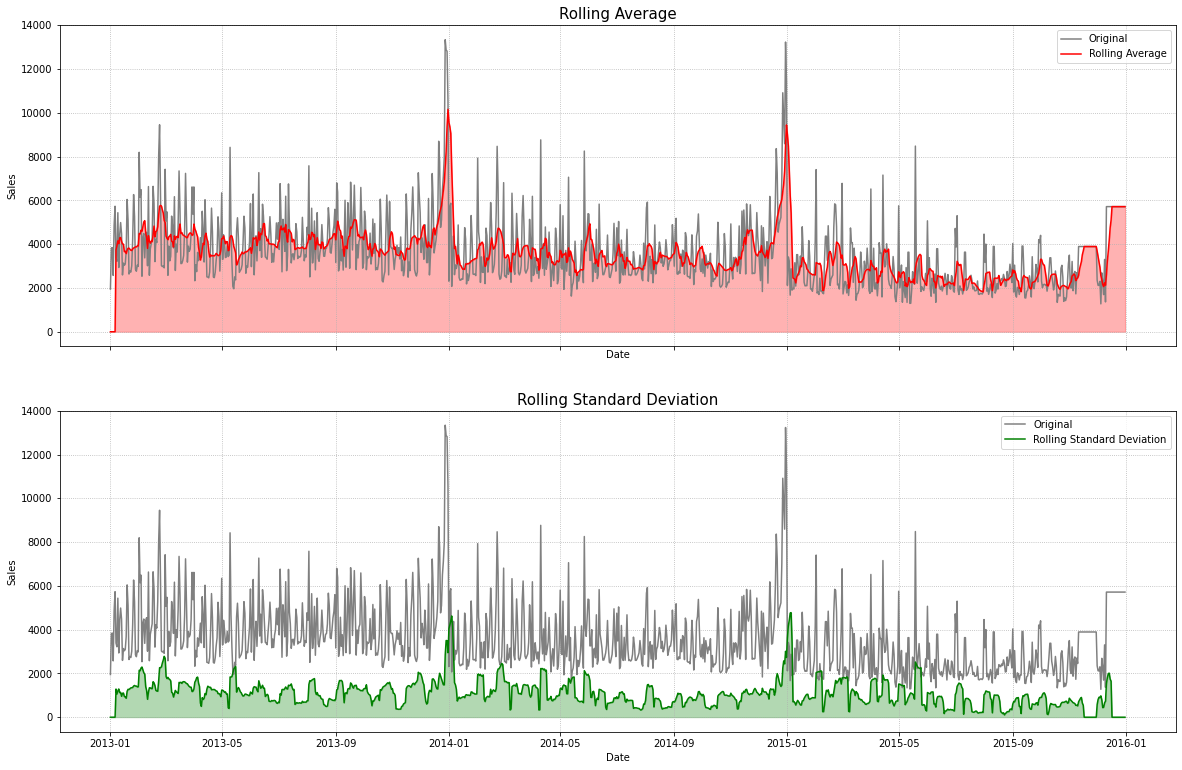

In [49]:
#plotting runnning average 
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(20,13))

metrics=[roll_average, roll_std]
subs = [ax1,ax2]
colors = ['red', 'green']
titles = ['Rolling Average', 'Rolling Standard Deviation']
i = 0

for ax in subs:
    fig.set_facecolor('white')
    ax.plot(sales, 'gray', label='Original')
    ax.set_title(titles[i], size=15)
    ax.plot(metrics[i], colors[i],  label=titles[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.grid(linestyle=':')
    ax.fill_between(metrics[i].index, 0, metrics[i], color=colors[i], alpha=0.3)
    ax.legend(loc='best')
    i += 1

plt.show()

**KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin)**<br>
<i>Assesing whether or not a time-series is stationary</i>

Hypothesis testing: <br>
$ \mu_0: \rho = 1 $  (Non-stationary Time Series) <br>
$ \mu_1: \rho < 1 $ (Stationary Time Series) 

In [50]:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


We reject the null hypothesis $ \rightarrow $ The data is not stationary

In [51]:
kpss_test(sales)

KPSS Statistic: 2.194559193938055
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [52]:
data = pd.DataFrame(sales[sales.index.year == 2013])
data['dayOfYear'] = data.index.dayofyear
#setting day of year as index
data = data.groupby('dayOfYear').sum()
#transforming to series
data = data.squeeze()
data.head()

dayOfYear
1    1951
2    3817
3    3846
4    2574
5    4863
Name: item_cnt_day, dtype: int32

<h5 style='margin-bottom:10px;'><strong><i>Identifying Seasonality in Data</i></strong></h5>
<span>Seasonality ocurs when the data follows a similar trend every certrain preiod of time </span>

***Seasonal Decompose***<br>
<i>StatsModels</i>

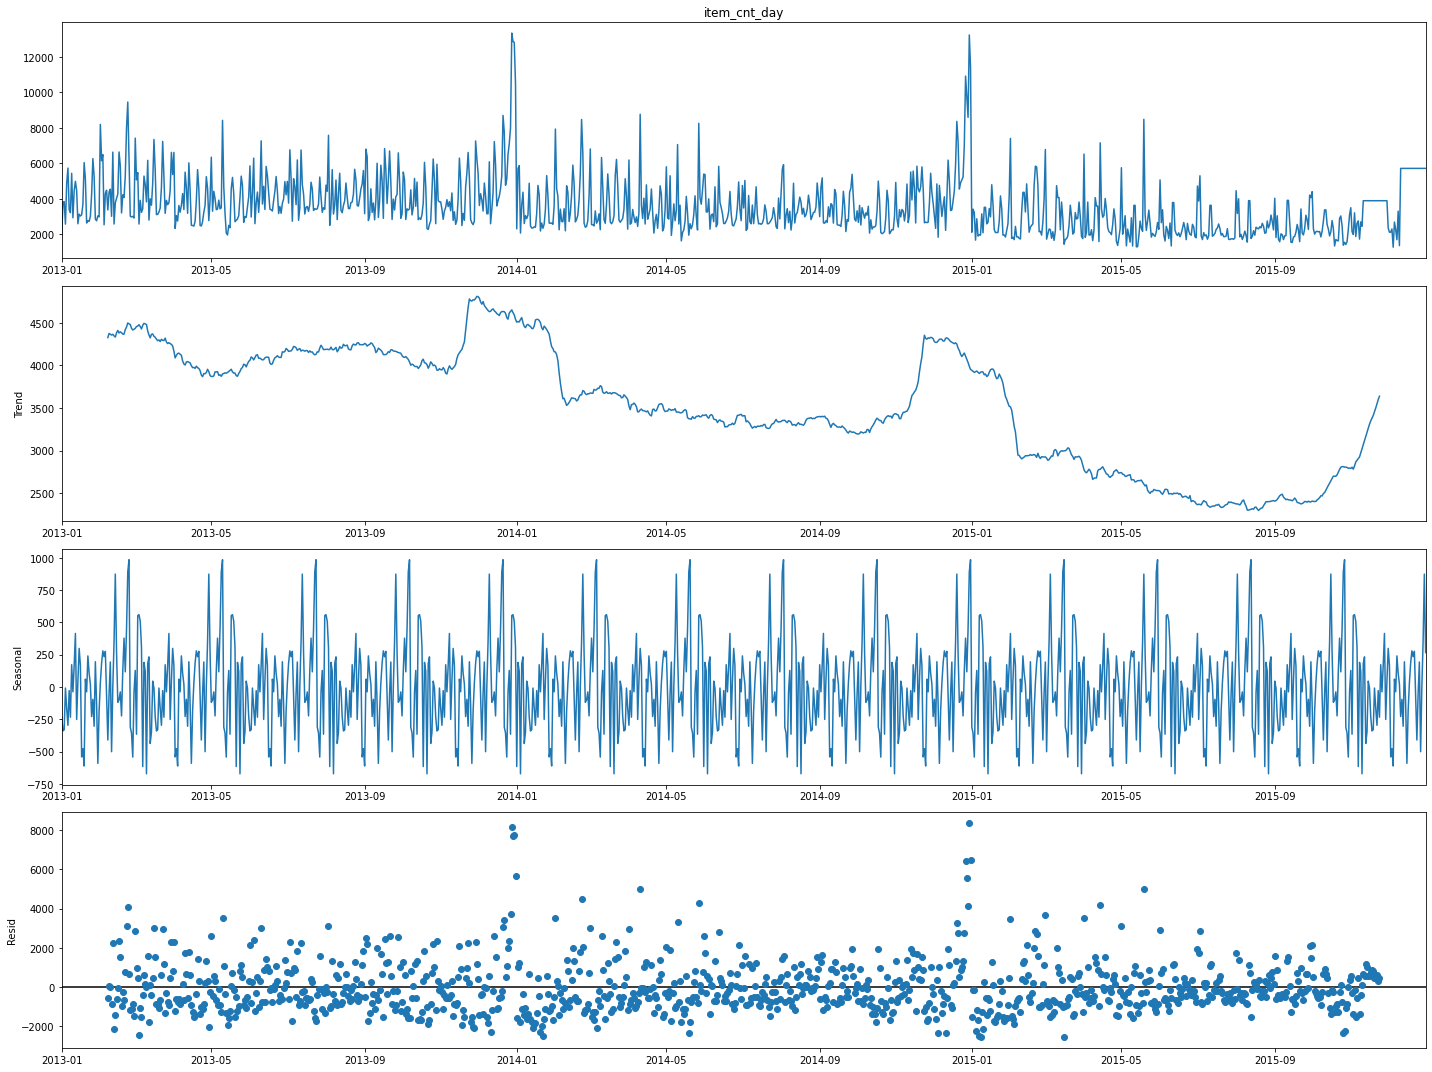

In [53]:
#setting figure size and face color
matplotlib.rc("figure", figsize=(20,15))
matplotlib.rc("figure", facecolor='white')

from statsmodels.tsa.seasonal import seasonal_decompose
#crating coppy of sales Series
sales_decom = sales.copy()
#defining seasonal decompose plots
decompose_result = seasonal_decompose(sales_decom, model='additive', period=75)
trend = decompose_result.trend 
seasonal = decompose_result.seasonal 
residual = decompose_result.resid 
#plotting graphs
decompose_result.plot()
plt.show()



<p><strong>Results:</strong> we can see that the data is definitely seasonal and it also follows some kind of downwards sloping trend</p>

____________________________

**Note** - Forecasting will be done in monthly periods<br>

### Exponential Smoothing
<i>Appropiate for non-stationary data (i.e; data with trend and seasonal data)</i>

Text(0, 0.5, 'Sales')

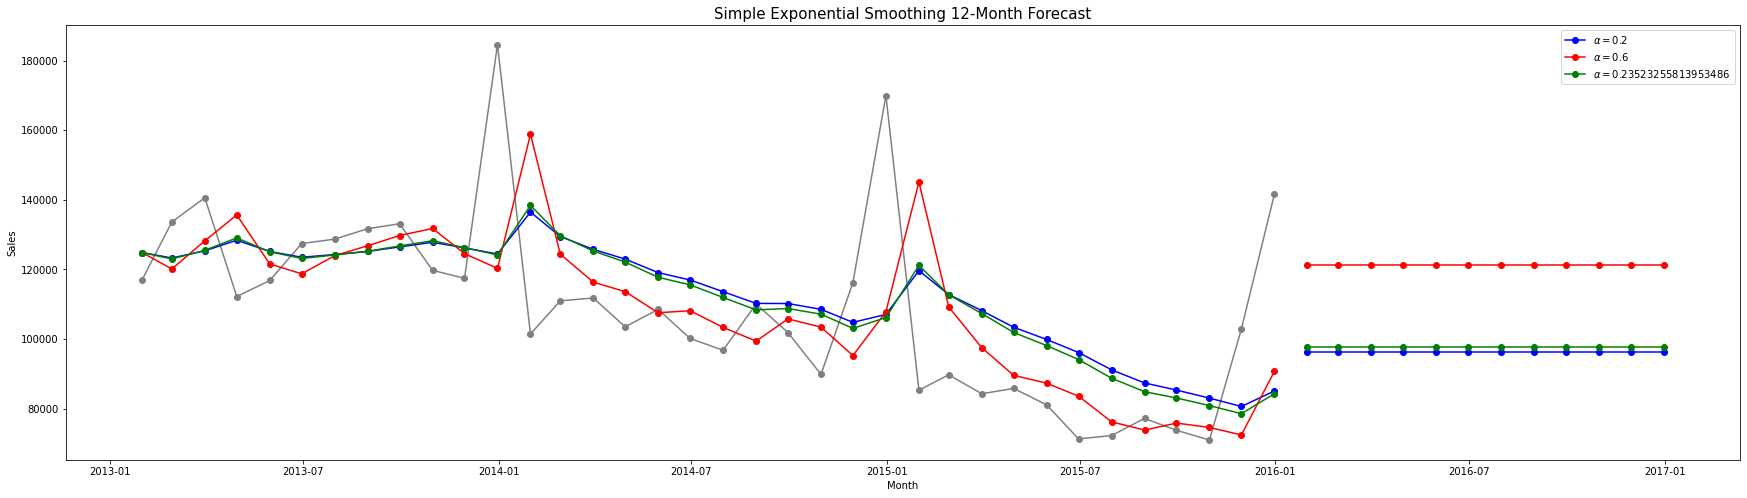

In [54]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
#Save algorithm for "Simple Exponential Smoothing"
fit1 = SimpleExpSmoothing(sales_month, initialization_method='heuristic').fit(smoothing_level=0.2, optimized=False)
#fitting data with alpha level 0.2
fcast1 = fit1.forecast(12).rename(r"$\alpha=0.2$")

fit2 = SimpleExpSmoothing(sales_month, initialization_method = 'heuristic').fit(smoothing_level=0.6, optimized=False)
fcast2 = fit2.forecast(12).rename(r"$\alpha=0.6$")

fit3 = SimpleExpSmoothing(sales_month, initialization_method="estimated").fit()
fcast3 = fit3.forecast(12).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(30,8))
plt.plot(sales_month, marker='o', color='gray')
plt.plot(fit1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

plt.title('Simple Exponential Smoothing 12-Month Forecast', size=15)
plt.xlabel('Month')
plt.ylabel('Sales')


Text(0, 0.5, 'Sales')

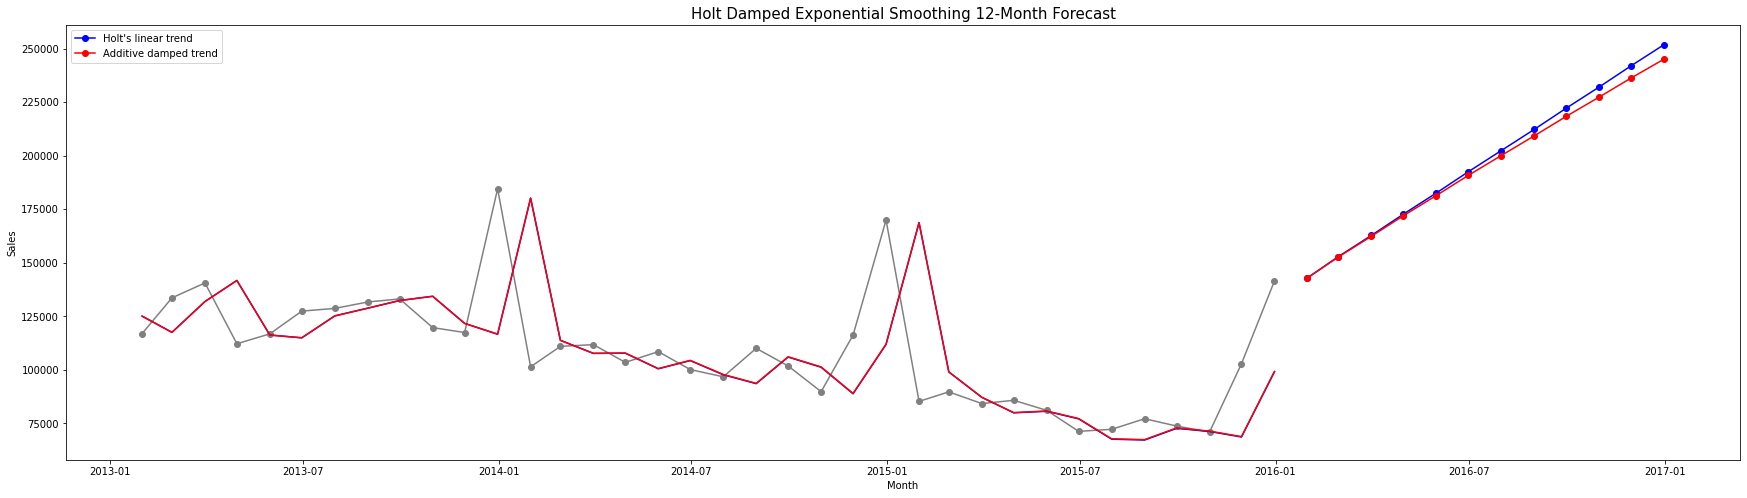

In [55]:
#Holt's linear trend
fit1 = Holt(sales_month, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")

#Additive damped trend
fit2 = Holt(sales_month, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2
)
fcast2 = fit2.forecast(12).rename("Additive damped trend")

plt.figure(figsize=(30, 8))
plt.plot(sales_month, marker="o", color="gray")
plt.plot(fit1.fittedvalues, color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
#Adding labels
plt.legend([line1, line2], [fcast1.name, fcast2.name])
plt.title('Holt Damped Exponential Smoothing 12-Month Forecast', size=15)
plt.xlabel('Month')
plt.ylabel('Sales')


In [95]:
fit1 = Holt(sales_month, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.predict(12).rename("Holt's linear trend")

In [96]:
fcast1

2014-01-31    180207.050311
2014-02-28    113802.004071
2014-03-31    107693.314172
2014-04-30    107784.325925
2014-05-31    100493.676127
2014-06-30    104318.317987
2014-07-31     97728.795481
2014-08-31     93547.563703
2014-09-30    105972.827155
2014-10-31    101218.867501
2014-11-30     88838.336770
2014-12-31    111871.776740
2015-01-31    168747.780456
2015-02-28     99035.176326
2015-03-31     87157.907288
2015-04-30     79947.428314
2015-05-31     80663.983989
2015-06-30     77109.537686
2015-07-31     67630.242396
2015-08-31     67233.384554
2015-09-30     72689.631457
2015-10-31     71226.219805
2015-11-30     68650.462305
2015-12-31     99136.836837
Freq: M, Name: Holt's linear trend, dtype: float64

### ARIMA 
<i>ARIMA models are a general class of models to forecast stationary time series</i><br>
<strong>Parameters:</strong><br>
<ul>
    <li>ARIMA(p,d,q)</li>
    <li>p = order of AR (Auto-regressive)</li>
    <li>q = order of MA (Moving Average)</li>
    <li>d = differencing order</li>
</ul>


**(1) Choosing Differencing Order (d)**<br>
<i>Analyse <strong>ACF</strong> (Autocorrelation Function) and <strong>PACF</strong> (Partial Autocorrelation Function) plots</i><br>
<ul>
    <li>A time series is made of series of observation from previous time steps</li>
    <li>Each time step is called a "lag"</li>
    <li>An Autocorrelation plot graphs the correlation between a series of observations across time</li>
</ul>

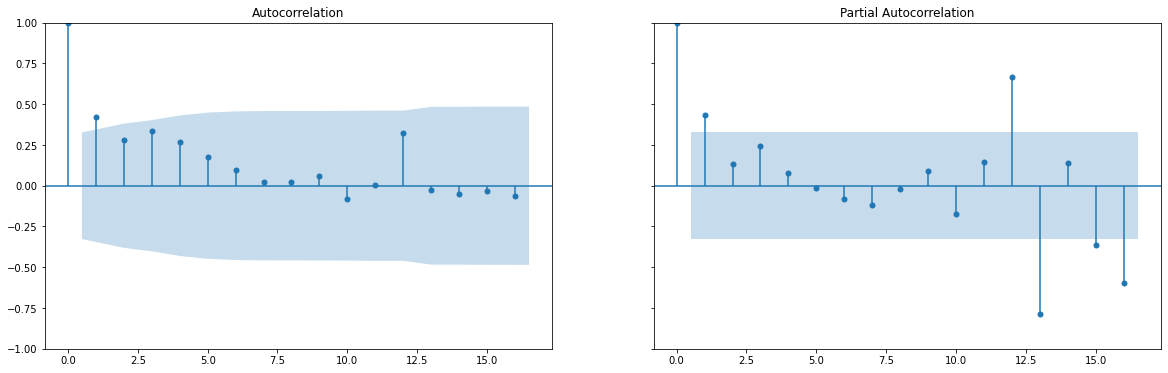

In [56]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,6))
#colored area --> Confidence Interval 95%
plot_acf(sales_month, ax=ax1)
plot_pacf(sales_month, ax=ax2)
plt.show()


**Is our data trend stationary?**<br>
<i>We can reject the null hypothesis that it is stationary --> It is non-stationary</i><br>
<span>We want our data to be stationary so that it is indipendent of time</span>

**Graphing Rolling Mean (Differencing Order 0 & 1)**<br>
<span>Visual representation of the purpose of differenciating your data. We can see how we've made the rolling mean fluctuate less across time. (i.e; Less time dependent)</span>

In [57]:
#Differenciating data
sales_diff_1 = sales
sales_diff_2 = sales_diff_1.diff()

In [58]:
#Rolling mean and variance for 0 order difference
roll_average_1 = sales_diff_1.rolling(window=7).mean()
roll_average_1 = roll_average_1.fillna(0)
roll_std_1 = sales_diff_1.rolling(window=7).std()
roll_std_1  = roll_std_1.fillna(0)

#Rolling mean and variance for 1st order difference
roll_average_2 = sales_diff_2.rolling(window=7).mean()
roll_average_2 = roll_average_2.fillna(0)
roll_std_2 = sales_diff_2.rolling(window=7).std()
roll_std_2  = roll_std_2.fillna(0)

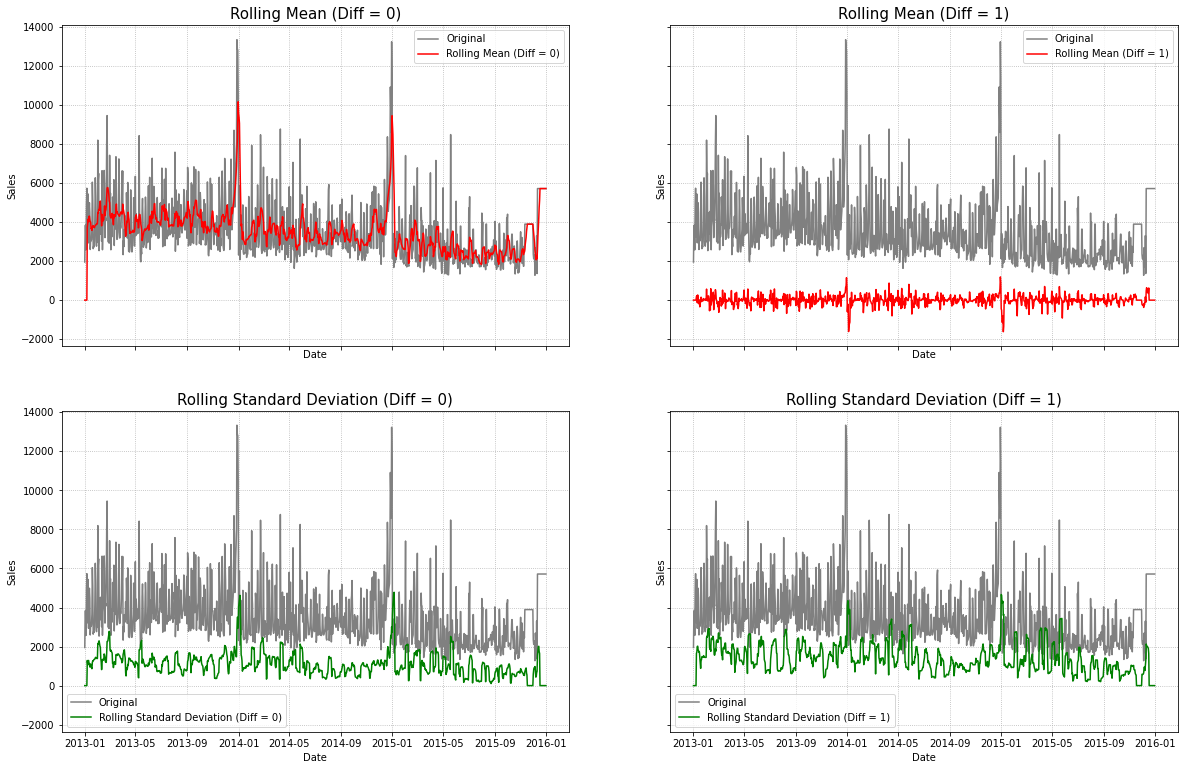

In [59]:
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2, sharex=True, sharey=True, figsize=(20,13))

metrics=[roll_average_1,roll_average_2, roll_std_1, roll_std_2]
subs = [ax1,ax2,ax3,ax4]
colors = ['red','red', 'green','green']
titles = ['Rolling Mean (Diff = 0)','Rolling Mean (Diff = 1)', 'Rolling Standard Deviation (Diff = 0)','Rolling Standard Deviation (Diff = 1)']
i = 0

for ax in subs:
    fig.set_facecolor('white')
    ax.plot(sales, 'gray', label='Original')
    ax.set_title(titles[i], size=15)
    ax.plot(metrics[i], colors[i],  label=titles[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.grid(linestyle=':')
    ax.legend()
    i += 1

plt.show()

***ARIMA Regression Model***<br>
We can see that a 1st order difference has a lower AIC score (Akaike Information Criterion)<br><br>
$AIC(ARIMA(0,0,0)) < AIC(ARIMA(0,1,0)) \rightarrow $ d=1 is the optimal Differenciating Order

In [60]:
from statsmodels.tsa.arima.model import ARIMA
#endogenous variable (Flattening Data in logarithmic representation)
endog = np.log(sales.values)

#Differentiating order 0
mod_arima = sm.tsa.arima.ARIMA(endog, order=(0, 0, 0))
res_0 = mod_arima.fit()
print(res_0.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1095
Model:                          ARIMA   Log Likelihood                -538.372
Date:                Thu, 04 Aug 2022   AIC                           1080.744
Time:                        10:12:01   BIC                           1090.741
Sample:                             0   HQIC                          1084.527
                               - 1095                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1015      0.012    660.665      0.000       8.077       8.126
sigma2         0.1565      0.007     22.772      0.000       0.143       0.170
Ljung-Box (L1) (Q):                 307.88   Jarque-

In [61]:
#Differenciating order 1 
mod_arima = sm.tsa.arima.ARIMA(endog, order=(0, 1, 0))
res_1 = mod_arima.fit()
print(res_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1095
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -503.119
Date:                Thu, 04 Aug 2022   AIC                           1008.237
Time:                        10:12:01   BIC                           1013.235
Sample:                             0   HQIC                          1010.128
                               - 1095                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1469      0.005     30.998      0.000       0.138       0.156
Ljung-Box (L1) (Q):                 101.82   Jarque-Bera (JB):               112.28
Prob(Q):                              0.00   Pr

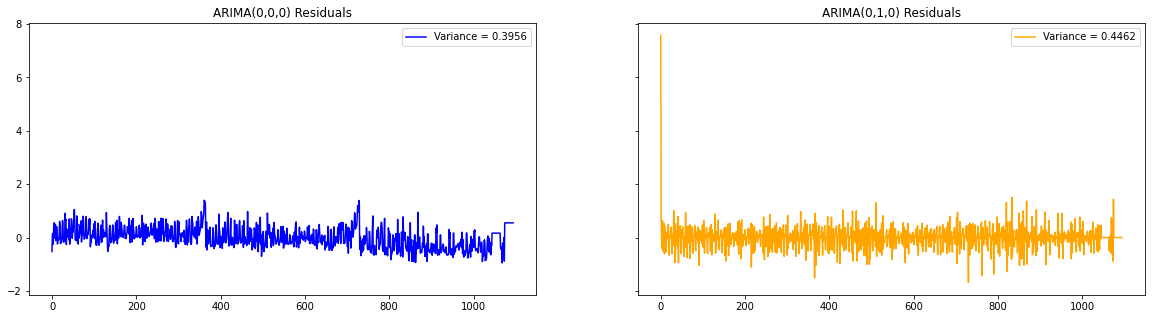

In [62]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,5))
axes = [ax1,ax2]
res = [res_0,res_1]
titles=['ARIMA(0,0,0) Residuals', 'ARIMA(0,1,0) Residuals']

colors=['blue','orange']
plt.title('helo')
for i in range(len(axes)):
    axes[i].plot(res[i].resid, color = colors[i])
    axes[i].legend(['Variance = '+str(round(res[i].resid.std(),4))])
    axes[i].set_title(titles[i])

plt.show()

**(2) Choosing the MA Order (p)**

In [63]:
mod_arima = sm.tsa.arima.ARIMA(endog, order=(0, 1, 0))
res_0 = mod_arima.fit()
print(res_0.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1095
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -503.119
Date:                Thu, 04 Aug 2022   AIC                           1008.237
Time:                        10:12:01   BIC                           1013.235
Sample:                             0   HQIC                          1010.128
                               - 1095                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1469      0.005     30.998      0.000       0.138       0.156
Ljung-Box (L1) (Q):                 101.82   Jarque-Bera (JB):               112.28
Prob(Q):                              0.00   Pr

In [64]:
mod_arima = sm.tsa.arima.ARIMA(endog, order=(1, 1, 0))
res_1 = mod_arima.fit()
print(res_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1095
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -449.728
Date:                Thu, 04 Aug 2022   AIC                            903.455
Time:                        10:12:01   BIC                            913.450
Sample:                             0   HQIC                           907.237
                               - 1095                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3052      0.028    -10.822      0.000      -0.361      -0.250
sigma2         0.1332      0.004     29.752      0.000       0.124       0.142
Ljung-Box (L1) (Q):                   8.20   Jarque-

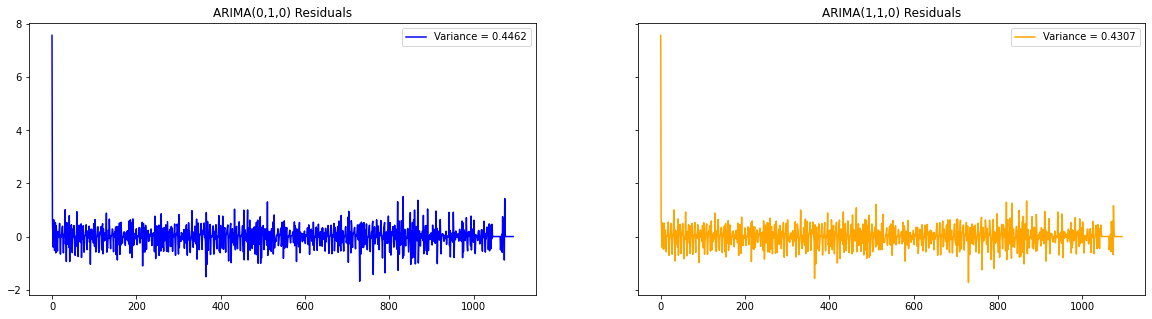

In [65]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,5))
axes = [ax1,ax2]
res = [res_0,res_1]
titles=['ARIMA(0,1,0) Residuals', 'ARIMA(1,1,0) Residuals']

colors=['blue','orange']
plt.title('helo')
for i in range(len(axes)):
    axes[i].plot(res[i].resid, color = colors[i])
    axes[i].legend(['Variance = '+str(round(res[i].resid.std(),4))])
    axes[i].set_title(titles[i])

plt.show()

***ACF | PACF Plot for ARIMA(1,1,0) Residuals***

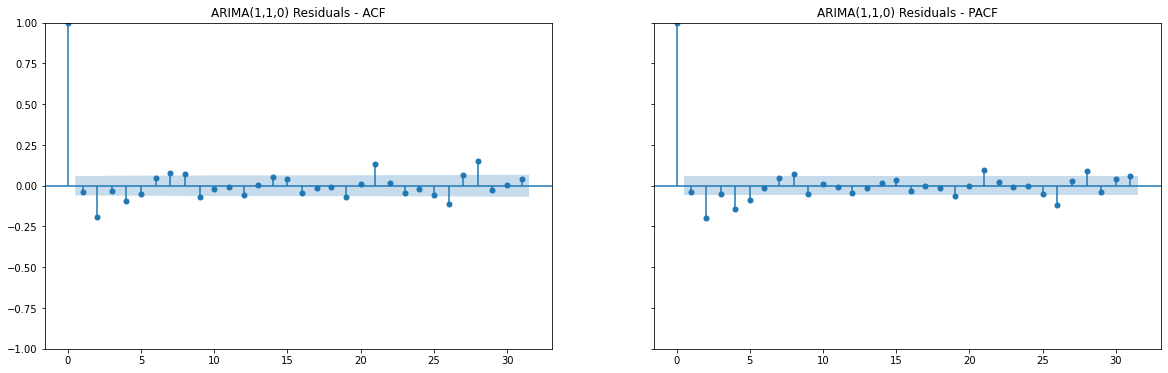

In [66]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,6))
#colored area --> Confidence Interval 95%
plot_acf(res_1.resid, ax=ax1, title='ARIMA(1,1,0) Residuals - ACF')
plot_pacf(res_1.resid, ax=ax2, title='ARIMA(1,1,0) Residuals - PACF')
plt.show()

**(3) Choosing AR Order (q)**

In [67]:
mod_arima = sm.tsa.arima.ARIMA(endog, order=(1, 1, 0))
res_0 = mod_arima.fit()
print(res_0.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1095
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -449.728
Date:                Thu, 04 Aug 2022   AIC                            903.455
Time:                        10:12:01   BIC                            913.450
Sample:                             0   HQIC                           907.237
                               - 1095                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3052      0.028    -10.822      0.000      -0.361      -0.250
sigma2         0.1332      0.004     29.752      0.000       0.124       0.142
Ljung-Box (L1) (Q):                   8.20   Jarque-

In [68]:
mod_arima = sm.tsa.arima.ARIMA(endog, order=(1, 1, 1))
res_1 = mod_arima.fit()
print(res_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1095
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -314.431
Date:                Thu, 04 Aug 2022   AIC                            634.862
Time:                        10:12:01   BIC                            649.855
Sample:                             0   HQIC                           640.536
                               - 1095                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3399      0.030     11.251      0.000       0.281       0.399
ma.L1         -0.9458      0.010    -94.456      0.000      -0.965      -0.926
sigma2         0.1039      0.004     24.674      0.0

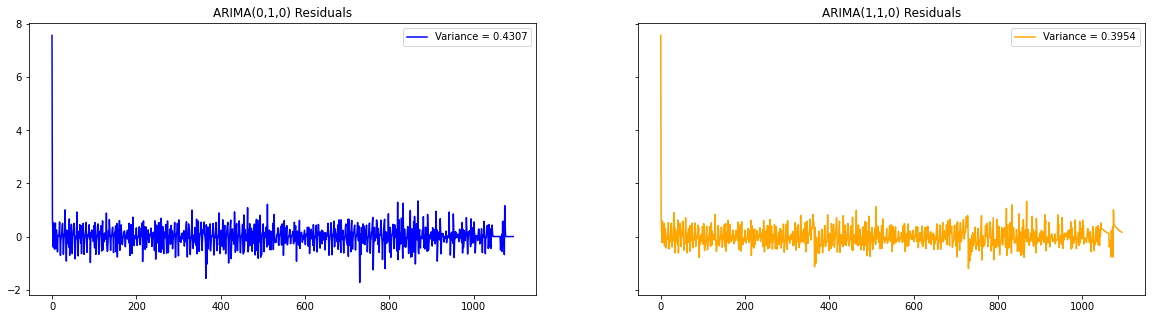

In [69]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,5))
axes = [ax1,ax2]
res = [res_0,res_1]
titles=['ARIMA(0,1,0) Residuals', 'ARIMA(1,1,0) Residuals']

colors=['blue','orange']
plt.title('helo')
for i in range(len(axes)):
    axes[i].plot(res[i].resid, color = colors[i])
    axes[i].legend(['Variance = '+str(round(res[i].resid.std(),4))])
    axes[i].set_title(titles[i])

plt.show()

With the chosen parameters, we've managed to make nearly all lag values uncorrelated with each other as we can see in the PACF graph

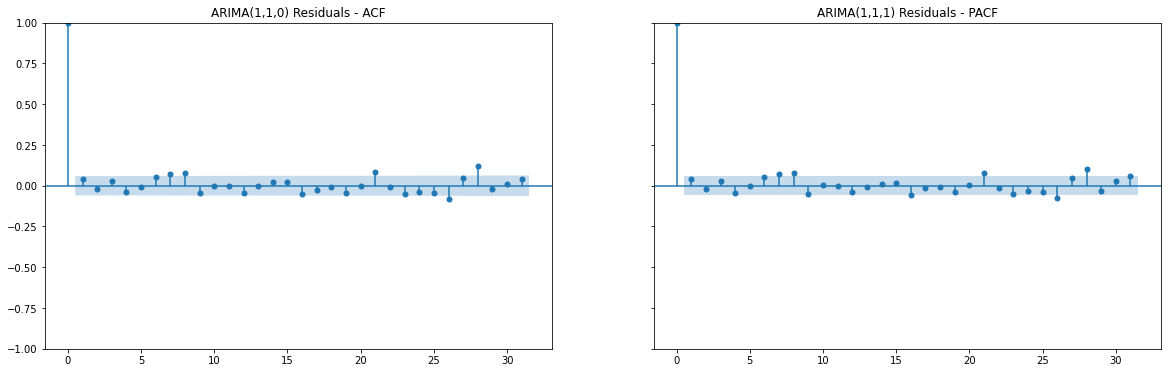

In [70]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,6))
#colored area --> Confidence Interval 95%
plot_acf(res_1.resid, ax=ax1, title='ARIMA(1,1,0) Residuals - ACF')
plot_pacf(res_1.resid, ax=ax2, title='ARIMA(1,1,1) Residuals - PACF')
plt.show()

<strong>Conclusion</strong> <br>
As the ARIMa model ARIMA(1,1,1) gives the lowest AIC values and it minimizes de dispersion of the residuals --> these are the best parameters for the regression model

**PLOTTING PREDICTIONS**

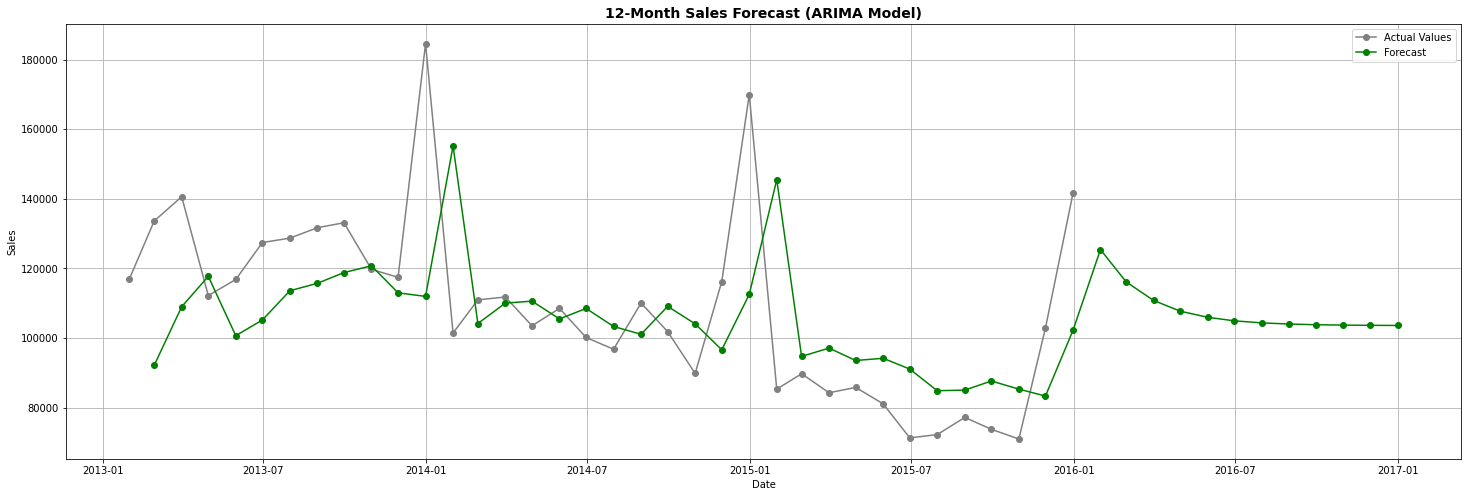

In [71]:
#Fitting Monthly Data to Regression
model_arima = sm.tsa.arima.ARIMA(pd.DataFrame(sales_month), order=(1, 1, 1))
res_1 = model_arima.fit()
res = res_1.predict('2013-02-28','2016-12-31')

#plotting results
figure(figsize=(25,8))
plt.grid()
plt.title('12-Month Sales Forecast (ARIMA Model)', size=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(sales_month, 'o-', color='gray')
plt.plot(res, 'o-', color='green')
plt.legend(['Actual Values','Forecast'])

### LSTM MODEL (Neural Network for Time Series)
<ul>
    <li>LSTM = Long Short-Term Memory Neural Network</li>
    <li>The most powerful Recurent Neural Network to do forecasting</li>
    <li>We use Scalecast library powered by TensorFlow and uses Seaborn as its graphing library
</li>
</ul>

**Exploratory Data Analysis with ScaleCast**

In [72]:
from scalecast.Forecaster import Forecaster
f = Forecaster(y=sales_month.values, current_dates=sales_month.index)
f

Forecaster(
    DateStartActuals=2013-01-31T00:00:00.000000000
    DateEndActuals=2015-12-31T00:00:00.000000000
    Freq=M
    N_actuals=36
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

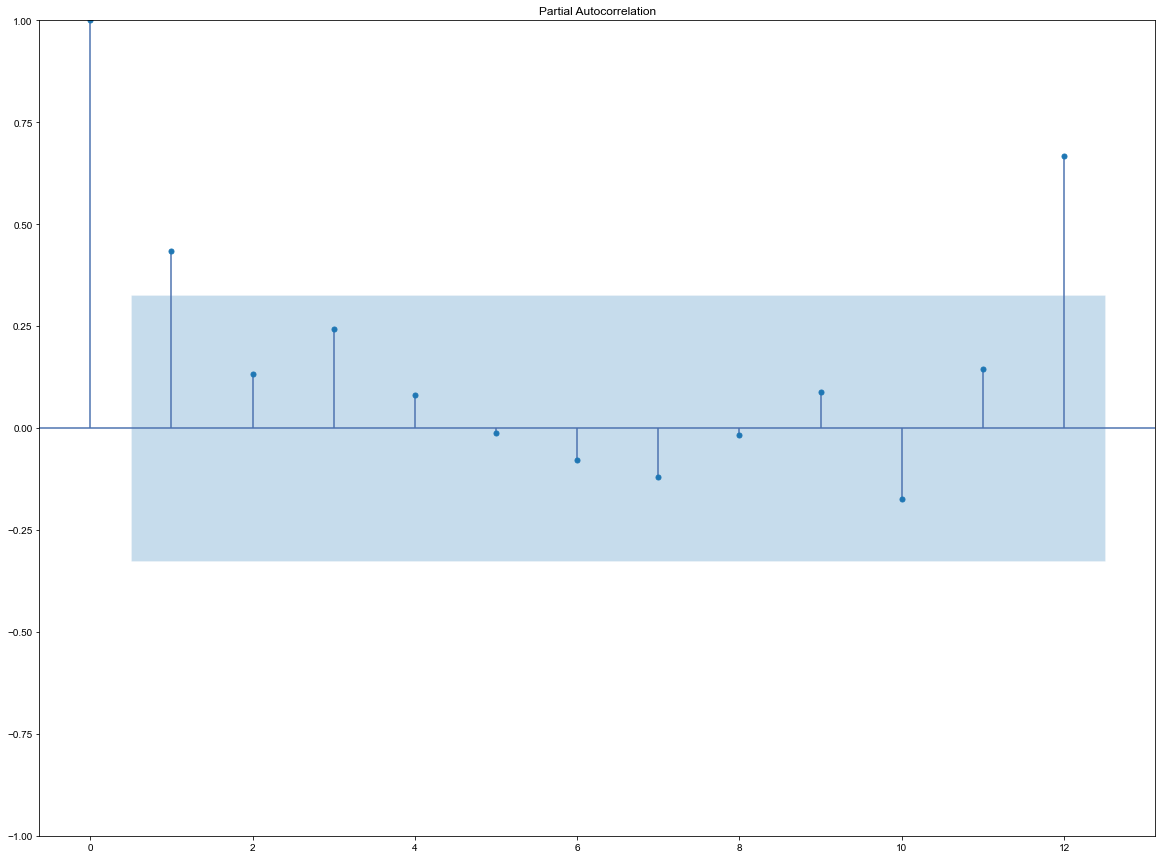

In [73]:
#Partial Autocorrelation plot 
f.plot_pacf(lags=12)
sns.set(rc={"figure.figsize": (12, 8)})
plt.show()

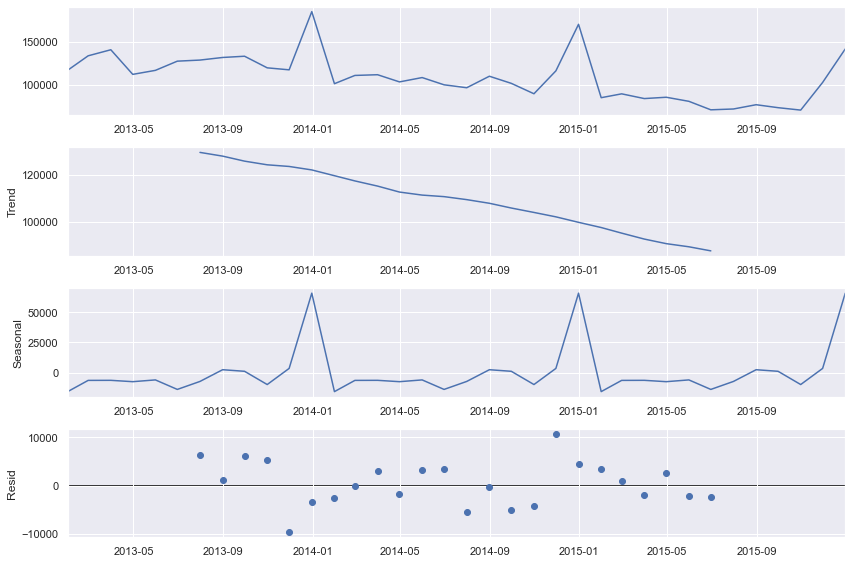

In [74]:
#sesonality and trend (Monthly Sales)
f.seasonal_decompose().plot()
sns.set(rc={"figure.figsize": (12, 8)})
plt.show()

Augmented Dickey Test

Hypothesis testing: <br>
$ \mu_0: \rho = 1 $  (Non-stationary Time Series) <br>
$ \mu_1: \rho < 1 $ (Stationary Time Series) <br>
<span>____________________________</span><br>
<i>P-value < </i>$\alpha = 0.05 \rightarrow$ <i>Series is Stationary</i>

In [75]:
#testing series stationarity (Augmented Dickey Test)
stat, p_value,_,_,_,_ = f.adf_test(full_res=True)
stat, p_value

(-3.4752433565678933, 0.008646131439112562)

In [76]:
#Creating Training and Test Sets
f.set_test_length(12)
#Generate Future Dates
f.generate_future_dates(12)
#Choose an estimator
f.set_estimator('lstm') #LSTM Neural Network

**Plotting Forecast**

1/1 [==============================] - 0s 11ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

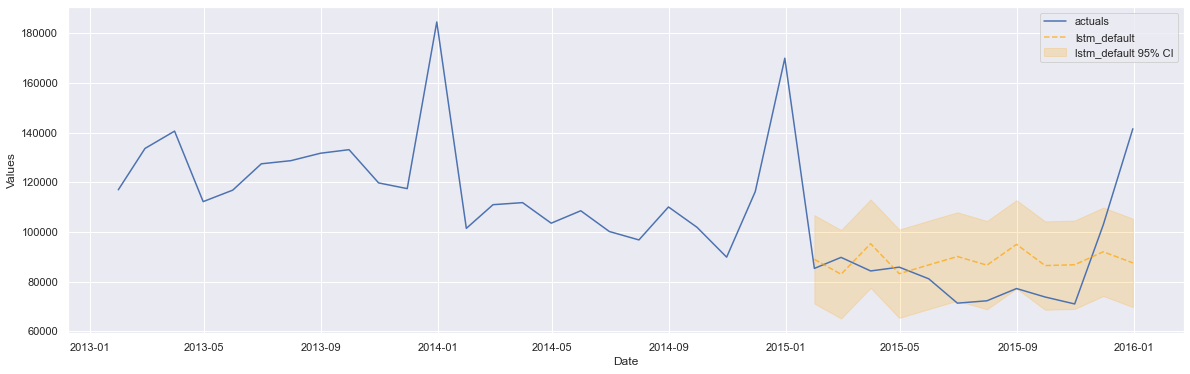

In [77]:
#Plot forecast
sns.set(rc={"figure.figsize": (20, 6)})
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

**Tunning Results**

Increasing Lags<br>
<i>The lag time is the time between the two time series you're correlating</i><br>
<i></i>

1/1 [==============================] - 0s 11ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

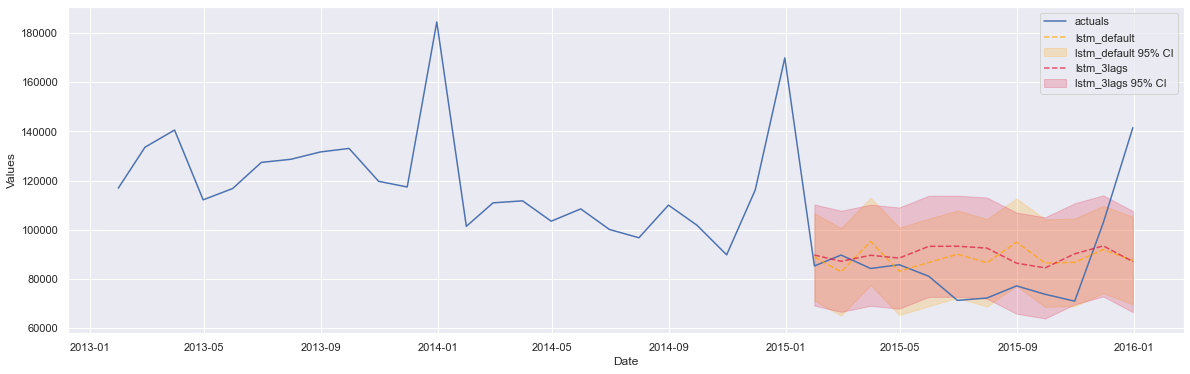

In [78]:
f.manual_forecast(call_me='lstm_3lags',lags=3)
f.plot_test_set(ci=True)

Adding more epochs to training

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 0.2775 - val_loss: 0.3667
Epoch 2/5
1/1 [==============================] - 0s 18ms/step - loss: 0.2756 - val_loss: 0.3648
Epoch 3/5
1/1 [==============================] - 0s 17ms/step - loss: 0.2737 - val_loss: 0.3630
Epoch 4/5
1/1 [==============================] - 0s 18ms/step - loss: 0.2718 - val_loss: 0.3611
Epoch 5/5
1/1 [==============================] - 0s 232ms/step
Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 0.2781 - val_loss: 0.4493
Epoch 2/5
1/1 [==============================] - 0s 17ms/step - loss: 0.2761 - val_loss: 0.4471
Epoch 3/5
1/1 [==============================] - 0s 17ms/step - loss: 0.2741 - val_loss: 0.4448
Epoch 4/5
1/1 [==============================] - 0s 16ms/step - loss: 0.2722 - val_loss: 0.4426
Epoch 5/5
1/1 [==============================] - 0s 11ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

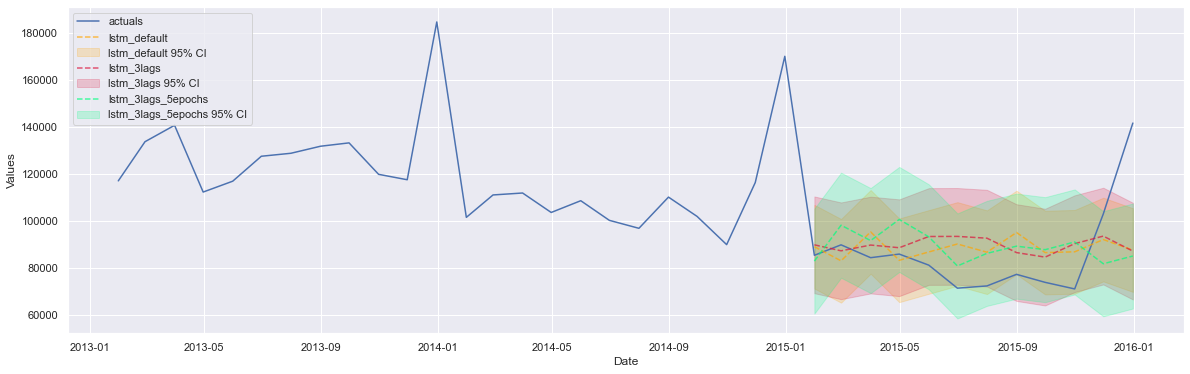

In [79]:
f.manual_forecast(call_me='lstm_3lags_5epochs',
                lags= 3, epochs=5, validation_split=0.2,
                shuffle=True)
                
f.plot_test_set(ci=True)

Increasing Neural Network Layers & Adding EarlyStopping

Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.2615 - val_loss: 0.3540
Epoch 2/5
1/1 [==============================] - 0s 18ms/step - loss: 0.2599 - val_loss: 0.3523
Epoch 3/5
1/1 [==============================] - 0s 19ms/step - loss: 0.2582 - val_loss: 0.3506
Epoch 4/5
1/1 [==============================] - 0s 19ms/step - loss: 0.2566 - val_loss: 0.3489
Epoch 5/5
1/1 [==============================] - 1s 648ms/step
Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.2648 - val_loss: 0.4351
Epoch 2/5
1/1 [==============================] - 0s 17ms/step - loss: 0.2628 - val_loss: 0.4330
Epoch 3/5
1/1 [==============================] - 0s 19ms/step - loss: 0.2609 - val_loss: 0.4309
Epoch 4/5
1/1 [==============================] - 0s 19ms/step - loss: 0.2589 - val_loss: 0.4288
Epoch 5/5
1/1 [==============================] - 0s 11ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

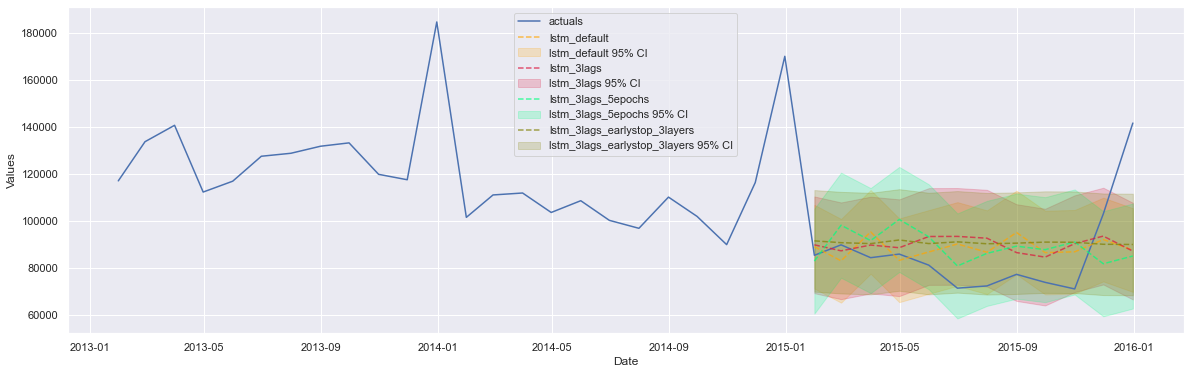

In [80]:
from tensorflow.keras.callbacks import EarlyStopping
f.manual_forecast(call_me='lstm_3lags_earlystop_3layers',
                lags=3,
                epochs=5,
                validation_split=0.2,
                shuffle=True,
                callbacks=EarlyStopping(monitor='val_loss',patience=5),
                lstm_layer_sizes=(16,16,16),
                dropout=(0,0,0))
sns.set(rc={"figure.figsize": (20, 6)})
f.plot_test_set(ci=True)

**Best Model Selection**<br>
<i>Using ADAM Optimizer</i>

Epoch 1/15
1/1 [==============================] - 5s 5s/step - loss: 0.2620 - val_loss: 0.3530
Epoch 2/15
1/1 [==============================] - 0s 20ms/step - loss: 0.2588 - val_loss: 0.3495
Epoch 3/15
1/1 [==============================] - 0s 20ms/step - loss: 0.2555 - val_loss: 0.3457
Epoch 4/15
1/1 [==============================] - 0s 20ms/step - loss: 0.2519 - val_loss: 0.3415
Epoch 5/15
1/1 [==============================] - 0s 20ms/step - loss: 0.2480 - val_loss: 0.3368
Epoch 6/15
1/1 [==============================] - 0s 21ms/step - loss: 0.2436 - val_loss: 0.3315
Epoch 7/15
1/1 [==============================] - 0s 22ms/step - loss: 0.2387 - val_loss: 0.3256
Epoch 8/15
1/1 [==============================] - 0s 21ms/step - loss: 0.2332 - val_loss: 0.3189
Epoch 9/15
1/1 [==============================] - 0s 21ms/step - loss: 0.2269 - val_loss: 0.3112
Epoch 10/15
1/1 [==============================] - 0s 19ms/step - loss: 0.2198 - val_loss: 0.3023
Epoch 11/15
1/1 [==============

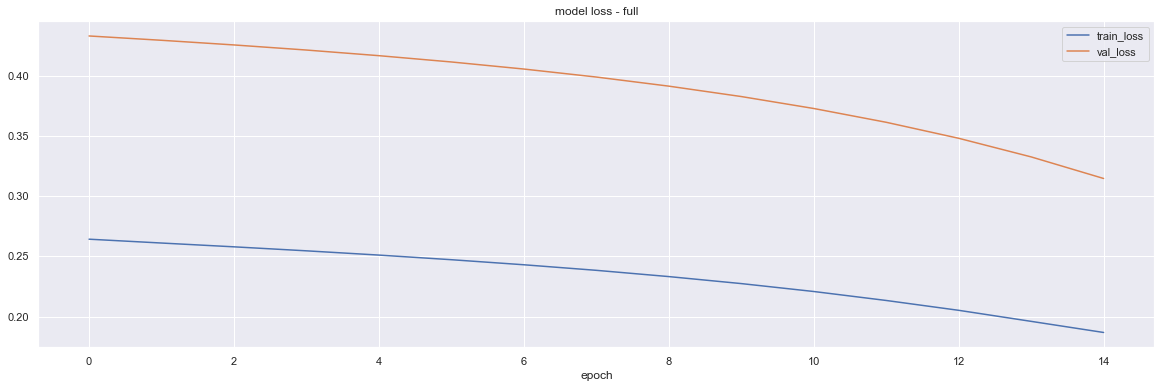

1/1 [==============================] - 0s 12ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

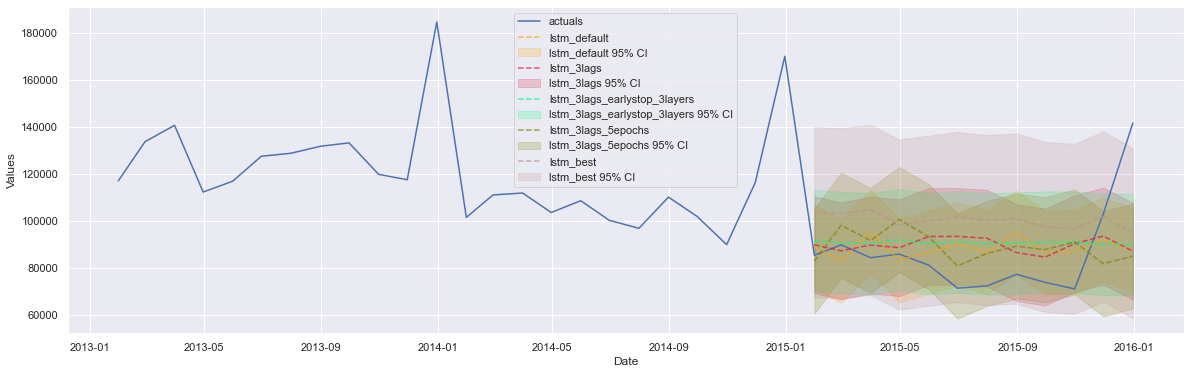

In [81]:
f.manual_forecast(call_me='lstm_best',
                  lags=3,
                  batch_size=32,
                  epochs=15,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)
f.plot_test_set(order_by='LevelTestSetMAPE',ci=True)

**Model 12-Month Prediction**

[Text(0.5, 1.0, 'LSTM Neural Network 12-month Forecast')]

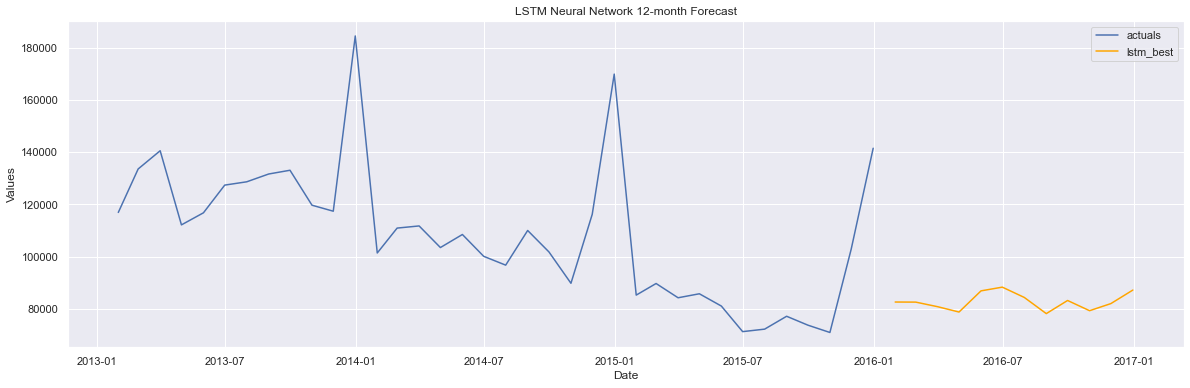

In [82]:
f.plot(models=['lstm_best'],level=True).set(title='LSTM Neural Network 12-month Forecast')

### FACEBOOK PROPHET ALGORITHM
"Facebook Prophet is an open-source algorithm for generating time-series models that uses a few old ideas with some new twists"

In [83]:
#\\\\ New library of prophet is called prophet not fbprophet
from prophet import Prophet

**Processing Data for Prophet**

In [84]:
#we must have a dataframe and two columns with names ds and y 
sales_proph = pd.DataFrame(sales_month).reset_index()
sales_proph = sales_proph.rename(columns = {'index':'ds','item_cnt_day':'y'})
sales_proph.ds = pd.to_datetime(sales_proph.ds)
sales_proph.head(2)

ds       y
0 2013-01-31  116950
1 2013-02-28  133607

**Training Model**

In [85]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(sales_proph)

10:12:41 - cmdstanpy - INFO - Chain [1] start processing
10:12:41 - cmdstanpy - INFO - Chain [1] done processing


**Forecast Away**

In [86]:
future = m.make_future_dataframe(periods=12, freq='M')
forecast  = m.predict(future)
forecast.head(3)

ds        trend     yhat_lower     yhat_upper  trend_lower  \
0 2013-01-31  8150.273087  114765.124907  126815.637089  8150.273087   
1 2013-02-28  6896.529802  130244.271600  142512.056106  6896.529802   
2 2013-03-31  5508.457028  134980.833423  147706.780270  5508.457028   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  8150.273087   112760.015413         112760.015413         112760.015413   
1  6896.529802   129485.625468         129485.625468         129485.625468   
2  5508.457028   135693.554860         135693.554860         135693.554860   

           daily    daily_lower    daily_upper        yearly  yearly_lower  \
0  129842.424152  129842.424152  129842.424152 -17082.408739 -17082.408739   
1  129842.424152  129842.424152  129842.424152   -356.798684   -356.798684   
2  129842.424152  129842.424152  129842.424152   5851.130708   5851.130708   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0 -17082.408739                   0.0                         0.0   
1   -356.798684                   0.0                         0.0   
2   5851.130708                   0.0                         0.0   

   multiplicative_terms_upper           yhat  
0                         0.0  120910.288500  
1                         0.0  136382.155271  
2                         0.0  141202.011888

In [87]:
#it has forecasted year 2016
forecast.tail(3)

ds         trend     yhat_lower     yhat_upper   trend_lower  \
45 2016-10-31 -75483.398911   44181.073647   56392.426449 -76644.308200   
46 2016-11-30 -77486.910153   30881.252402   44022.754913 -78847.801647   
47 2016-12-31 -79557.205103  114506.207043  127109.413644 -81099.141172   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
45 -74237.935614   125834.503778         125834.503778         125834.503778   
46 -76071.541391   115052.047328         115052.047328         115052.047328   
47 -77945.606349   200425.631943         200425.631943         200425.631943   

            daily    daily_lower    daily_upper        yearly  yearly_lower  \
45  129842.424152  129842.424152  129842.424152  -4007.920374  -4007.920374   
46  129842.424152  129842.424152  129842.424152 -14790.376824 -14790.376824   
47  129842.424152  129842.424152  129842.424152  70583.207791  70583.207791   

    yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
45  -4007.920374                   0.0                         0.0   
46 -14790.376824                   0.0                         0.0   
47  70583.207791                   0.0                         0.0   

    multiplicative_terms_upper           yhat  
45                         0.0   50351.104867  
46                         0.0   37565.137175  
47                         0.0  120868.426839

**Plotting Forecast**

Text(129.75, 0.5, 'Values')

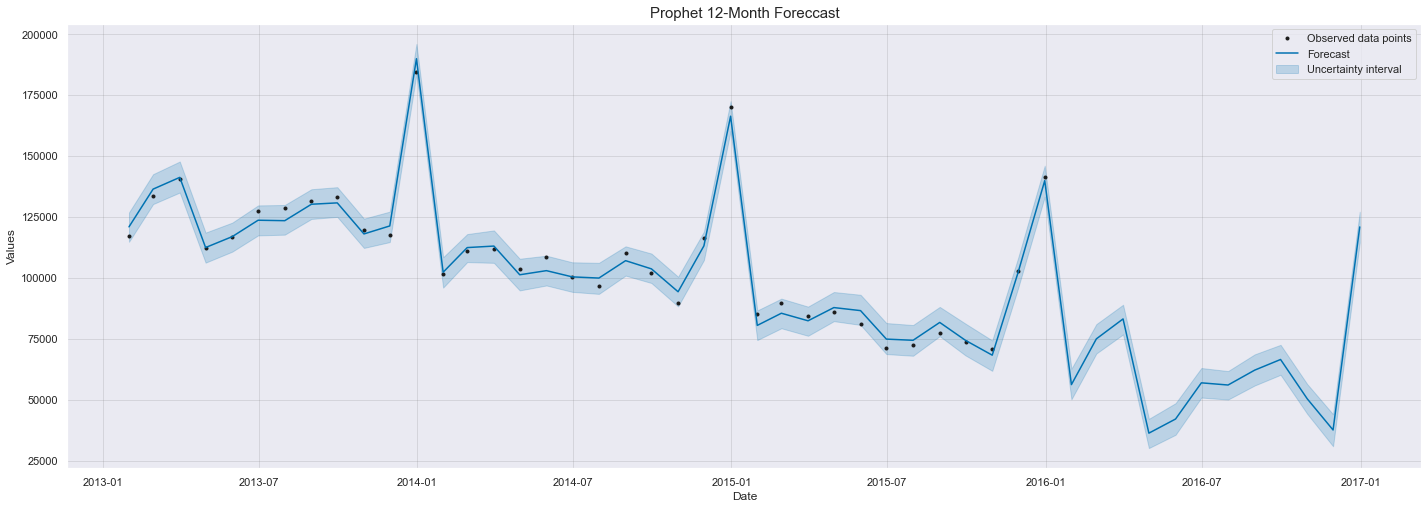

In [88]:
from prophet.plot import plot
#uses Matplotlib
plot = plot(m, forecast, figsize=(20, 7))
plt.title('Prophet 12-Month Foreccast', size=15)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Values')


### COMPARING ALL MODELS

**SIMPLE EXPONENTIAL SMOOTHING**

Text(0, 0.5, 'Sales')

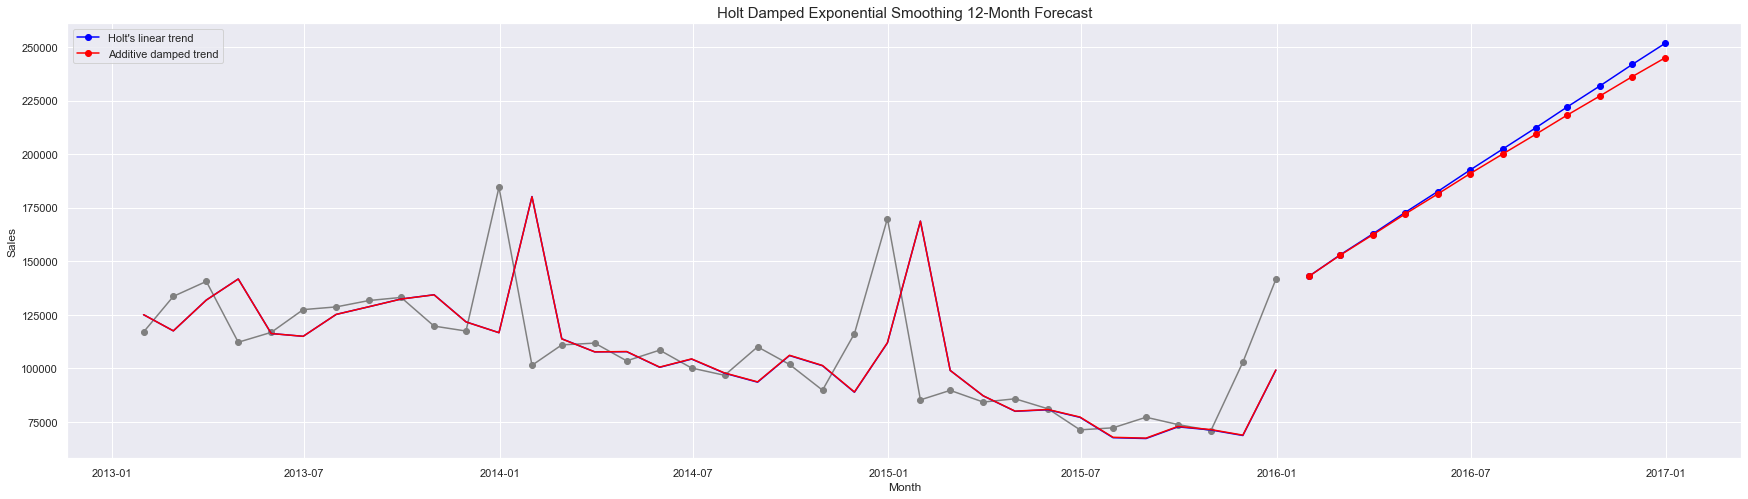

In [89]:
#Holt's linear trend
fit1 = Holt(sales_month, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")

#Additive damped trend
fit2 = Holt(sales_month, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2
)
fcast2 = fit2.forecast(12).rename("Additive damped trend")

plt.figure(figsize=(30, 8))
plt.plot(sales_month, marker="o", color="gray")
plt.plot(fit1.fittedvalues, color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
#Adding labels
plt.legend([line1, line2], [fcast1.name, fcast2.name])
plt.title('Holt Damped Exponential Smoothing 12-Month Forecast', size=15)
plt.xlabel('Month')
plt.ylabel('Sales')

**ARIMA**

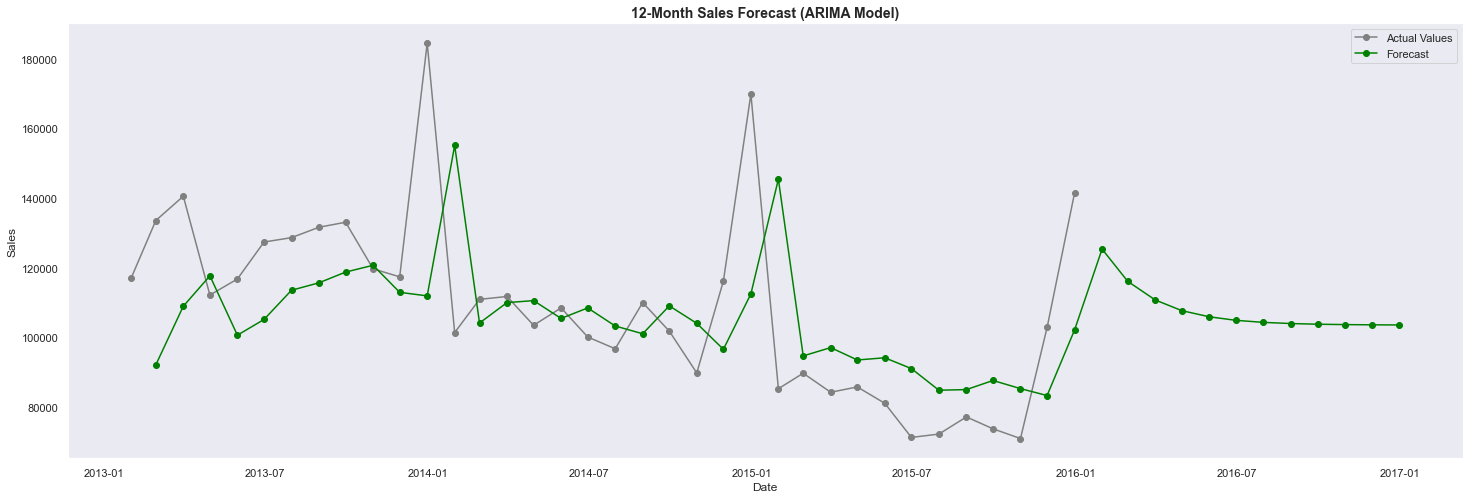

In [90]:
#Fitting Monthly Data to Regression
model_arima = sm.tsa.arima.ARIMA(pd.DataFrame(sales_month), order=(1, 1, 1))
res_1 = model_arima.fit()
res = res_1.predict('2013-02-28','2016-12-31')

#plotting results
figure(figsize=(25,8))
plt.grid()
plt.title('12-Month Sales Forecast (ARIMA Model)', size=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(sales_month, 'o-', color='gray')
plt.plot(res, 'o-', color='green')
plt.legend(['Actual Values','Forecast'])

**LSTM NEURAL NETWORK**

[Text(0.5, 1.0, 'LSTM Neural Network 12-month Forecast')]

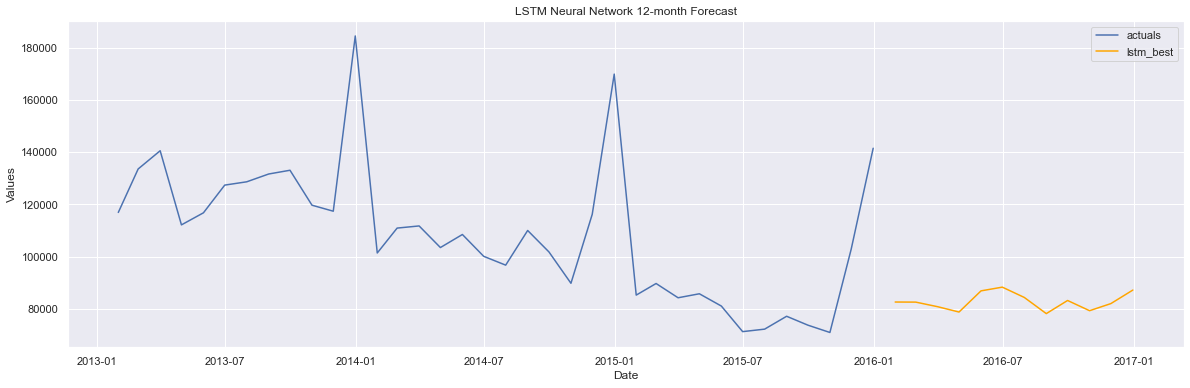

In [91]:
f.plot(models=['lstm_best'],level=True).set(title='LSTM Neural Network 12-month Forecast')

**FACEBOOK PROPHET**

In [92]:
sales_proph.tail()

ds       y
31 2015-08-31   77171
32 2015-09-30   73763
33 2015-10-31   70962
34 2015-11-30  102870
35 2015-12-31  141541

Text(129.75, 0.5, 'Values')

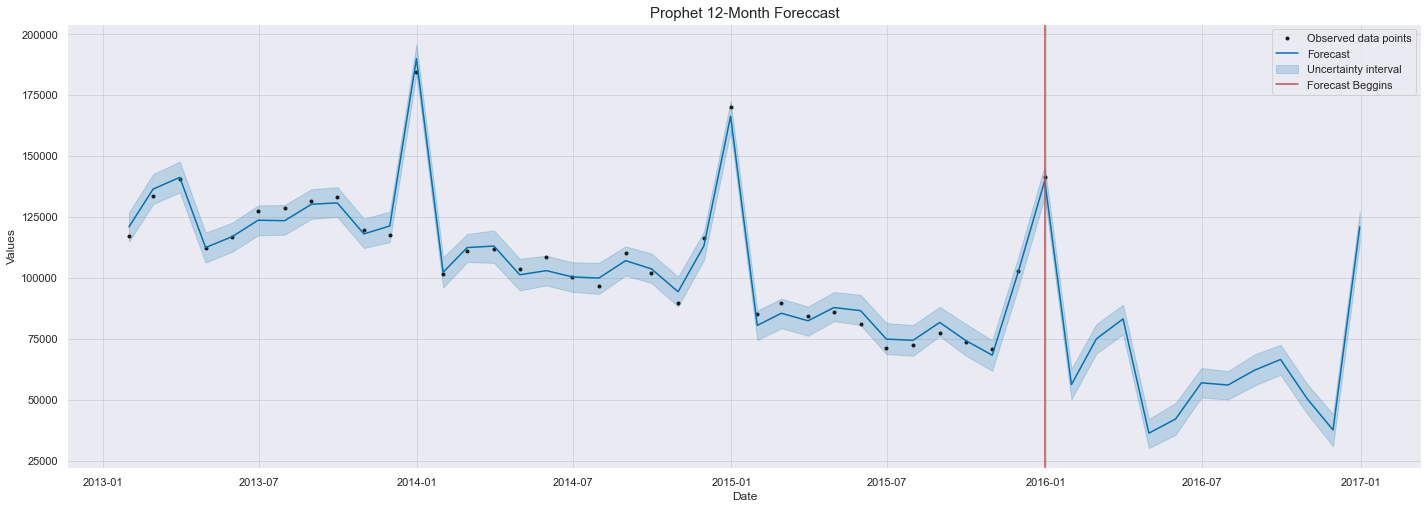

In [93]:
from prophet.plot import plot
plot = plot(m, forecast, figsize=(20, 7))
plt.title('Prophet 12-Month Foreccast', size=15)
plt.axvline(x = pd.to_datetime('2015-12-31'), color = 'r', label = 'Forecast Beggins')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Values')

### SUMMARY
From all the forecasting models used for the time series analysis, we can clearly notice that the best performing ones were: LSTM Neural Network and Prophet Algorithm. <br>
Both of this models accurately predict the long-term downward trend and the annual seasonality where sales increase throughout December and January. 